# Fine-Tuning a Vision-Language Model (Qwen2-VL-7B) with the HuggingFace Ecosystem (TRL)

In this example, we will fine-tune a [`Qwen-2-VL-7B`](https://qwenlm.github.io/blog/qwen2-vl/) model on the [`ChartQA`](https://huggingface.co/datasets/HuggingFaceM4/ChartQA) dataset. This dataset includes images of various chart types paired with question-answer pairs.

## Setups

In [ ]:
!pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes peft qwen-vl-utils wandb accelerate
# Tested with transformers==4.47.0.dev0, trl==0.12.0.dev0, datasets==3.0.2, bitsandbytes==0.44.1, peft==0.13.2, qwen-vl-utils==0.0.8, wandb==0.18.5, accelerate==1.0.1

In [ ]:
!pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Load Dataset

We need to generate a system message for the VLM. In this case, we want to create a system that acts as an expert in analyzing chart images and providing concise answers to questions based on them.

In [3]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

Then we will format the dataset into a chatbot struture for interaction. Each interaction will consist of a system message, followed by the image and the user's query, and finally, the answer to the query.

In [4]:
def format_data(sample):
    return [
        {
            'role': 'system',
            'content': [
                {
                    'type': 'text',
                    'text': system_message
                }
            ]
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                    'image': sample['image']
                },
                {
                    'type': 'text',
                    'text': sample['query']
                }
            ]
        },
        {
            'role': 'assistant',
            'content': [
                {
                    'type': 'text',
                    'text': sample['label'][0]
                }
            ]
        }
    ]

For demo purpose, we will only load 10% of each split in the dataset.

In [ ]:
from datasets import load_dataset

dataset_id = 'HuggingFaceM4/ChartQA'
train_dataset, eval_dataset, test_dataset = load_dataset(
    dataset_id,
    split=['train[:10%]', 'val[:10%]', 'test[:10%]']
)

In [6]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

The dataset includes an image, a query, a label (which is the answer), and a feature called `'human_or_machine'` that we will discard.

In [7]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>,
 'query': 'Is the value of Favorable 38 in 2015?',
 'label': ['Yes'],
 'human_or_machine': 0}

Now we can format the data into the format we want:

In [8]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [9]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

## Load model

We will load [`Qwen/Qwen2-VL-7B-Instruct`](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct), a Vision-Language Model (VLM) capable of understanding both visual data and text.

The alternatives are
* Meta AI's `Llama-3.2-11B-Vision`
* Mistral AI's `Pixtral-12B`
* Allen AI's `Molmo-7B-D-0924`

In [ ]:
import torch
from transformers import Qwen2VLProcessor, Qwen2VLForConditionalGeneration

model_id = 'Qwen/Qwen2-VL-7B-Instruct'

processor = Qwen2VLProcessor.from_pretrained(model_id)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16
)

In [11]:
example_test = train_dataset[0]

The input message only contains the user's message

In [12]:
example_test[1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

This also includes a chart image:

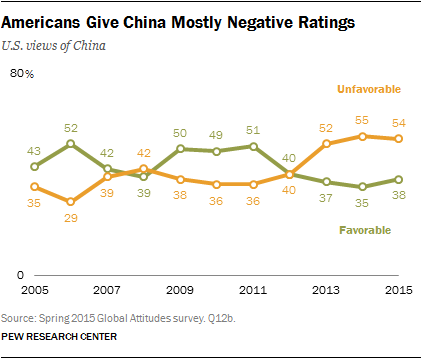

In [13]:
example_test[1]['content'][0]['image']

Next, we will create a method that takes the model, processor, and sample as inputs to generate the model's answer. This will allow us to streamline the inference process and easily evaluate the VLM's performance.

In [16]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device='cuda'):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], # use the sample without the system message
        tokenize=False,
        add_generation_prompt=True
    )
    print(f"Before applying chat template:\n{sample[1:2]}")
    print('-'*50)
    print(f"After applying chat template:\n{text_input}")
    print('-'*50)

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors='pt'
    ).to(device)

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs['input_ids'], generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0] # return the first decoded output text

In [17]:
# show example of how to call the method with sample
output = generate_text_from_sample(model, processor, example_test)
output

Before applying chat template:
[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359 at 0x781F683BC6D0>}, {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]
--------------------------------------------------
After applying chat template:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Is the value of Favorable 38 in 2015?<|im_end|>
<|im_start|>assistant

--------------------------------------------------


'No, the value of Favorable is not 38 in 2015. According to the chart, the value of Favorable in 2015 is 38.'

### Remove model and clean GPU

Some cleanup work is needed before proceeding for fine-tuning

In [18]:
import gc
import time

def clear_memory():
    # delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


## Fine-tune the model using `trl`

### Load the quantized model for training

We will load the quantized model using `bitsandbytes`.

In [ ]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
processor = Qwen2VLProcessor.from_pretrained(model_id)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

### Set up Q-LoRA and `SFTConfig`

Next, we will configure **Q-LoRA** for our training setup.

**Q-LoRA** enables efficient fine-tuning of large language models while significantly reducing the memory footprint compared to traditional methods. Unlike standard LoRA, which reduces memory usage by applying a low-rank approximation, Q-LoRA takes it a step further by quantizing the weights of the LoRA adapters. This leads to even lower memory requirements and improved training efficiency, making it an excellent choice for optimizing our model's performance without sacrificing quality.

In [ ]:
from peft import LoraConfig, get_peft_model

# configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias='none',
    target_modules=['q_proj', 'v_proj'],
    task_type='CAUSAL_LM'
)

# apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# check trainable parameters
peft_model.print_trainable_parameters()

In this example, we will use **Supervised Fine-Tuning (SFT)** to refine our model's performance on the task at hand. To do this, we will define the training arguments using the `SFTConfig` class from the `trl` library.

SFT allows us to provide labeled data, helping the model learn to generate more accurate responses based on the input it receives. This approach ensures that the model is tailored to our specific use case, leading to better performance in understanding and responding to visual queries.

In [ ]:
from trl import SFTConfig

# configure training arguments
training_args = SFTConfig(
    output_dir='qwen2-7b-instruct-trl-sft-ChartQA',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8, # steps to accumulate gradients
    gradient_checkpointing=True, # enable gradient checkpointing for memory efficiency

    # optimizer and scheduler settings
    optim='adamw_torch_fused',
    learning_rate=2e-4,
    lr_scheduler_type='constant',

    # logging and evaluation
    logging_steps=10
    eval_steps=10,
    eval_strategy='steps',
    save_steps=20,
    save_strategy='steps',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,

    # mixed precision and gradient settings
    bf16=True, # use bfloat16 precision
    tf32=True, # use TensorFloat-32 precision
    max_grad_norm=0.3, # maximum norm for gradient clipping
    warmup_ratio=0.03, # ratio of total steps for warmup

    # hub and reporting
    push_to_hub=False,
    report_to='wandb', # reporting tool for tracking metrics
    # gradient checkpointing settings
    gradient_checkpointing_kwargs={'use_reentrant': False},
    # dataset configuration
    dataset_text_field="", # text field in dataset
    dataset_kwargs={'skip_prepare_dataset': True},
    remove_unused_columns=False, # keep unused columns in dataset
)

### Train the model

We will log our training progress using `wandb` (Weights & Biases)

In [ ]:
import wandb

wandb.init(
    project='qwen2-7b-instruct-trl-sft-ChartQA',
    name='qwen2-7b-instruct-trl-sft-ChartQA',
    config=training_args
)

We need a collator function to properly retrieve and batch the data during the training procedure. This function will handle the formatting of our dataset inputs, ensuring they are correctly structured for the model.

In [ ]:
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [
        processor.apply_chat_template(example, tokenize=False)
        for example in examples
    ] # prepare texts for processing
    image_inputs = [
        process_vision_info(example)[0]
        for example in examples
    ] # process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(
        texts=texts,
        images=image_inputs,
        return_tensors='pt',
        padding=True
    )

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch['input_ids'].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100 # mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652, 151653, 151655] # specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)] # convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100

    batch['labels'] = labels

    return batch

Now, we can define the `SFTTrainer`.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer
)

In [ ]:
trainer.train()
trainer.save_model(training_args.output_dir)

## Test the fine-tuned model

In [ ]:
clear_memory()

We will reload the base model using the same pipeline as before

In [19]:
processor = Qwen2VLProcessor.from_pretrained(model_id)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Next, we will attach the trained Q-LoRA adapter to the pretrained model. This adapter contains the fine-tuning adjustments we made during training, allowing the base model to leverage the new knowledge without altering its core parameters. By integrating the adapter, we can enhance the model's capabilities while maintaining its original structure.

In [ ]:
adapter_path = "sergiopaniego/qwen2-7b-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

We still use the same example from the dataset for testing:

In [ ]:
example_test[:2]

In [ ]:
example_test[1]['content'][0]['image']

In [ ]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

We also want to evalaute on the example from the test dataset, of course:

In [ ]:
example_test = test_dataset[0]
example_test[:2]

In [ ]:
example_test[1]['content'][0]['image']

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[10])
output

## Compare fine-tuned model with base model + prompting

Another approach rather than fine-tuning si directly using prompting or implementing a RAG system.

Fine-tuning VLM requires significant amounts of data and computational resources, which can incur costs. In contrast, we can also experiment with prompting to see if we can achieve similar results without the overhead of fine-tuning.

In [ ]:
clear_memory()

In [ ]:
processor = Qwen2VLProcessor.from_pretrained(model_id)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16
)

In [ ]:
example_test[:2]

In [ ]:
example_test[1]['content'][0]['image']

Now we use the system message as additional prompting:

In [ ]:
text = processor.apply_chat_template(
    example_test[:2] # use the sample with system message
    tokenize=False,
    add_generation_prompt=True
)

image_inputs, _ = process_vision_info(example_test)

inputs = processor(
    text=[text],
    images=image_inputs,
    return_tensors='pt'
).to('cuda')

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
output_text[0]

Depending on specific use case, we may want to explore and decide which approach we want to go with.